In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, rmse
from darts import concatenate

/opt/homebrew/anaconda3/envs/Torch_practice/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import logging
logging.disable(logging.CRITICAL)

In [4]:
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [5]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(12, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "MAPE: {}".format(mape(scaler.transform(ts_transformed.univariate_component(0)), scaler.transform(pred_series)))+"/"
        "RMSE: {}".format(rmse(scaler.transform(ts_transformed.univariate_component(0)), scaler.transform(pred_series)))
    )
    plt.legend()

,Monthly Anamoly
DateTime,
1880-01-01,-5.194
1880-02-01,-1.075
1880-03-01,4.233
1880-04-01,9.538
1880-05-01,15.957


Text(0.5, 1.0, 'Jakarta Temp')

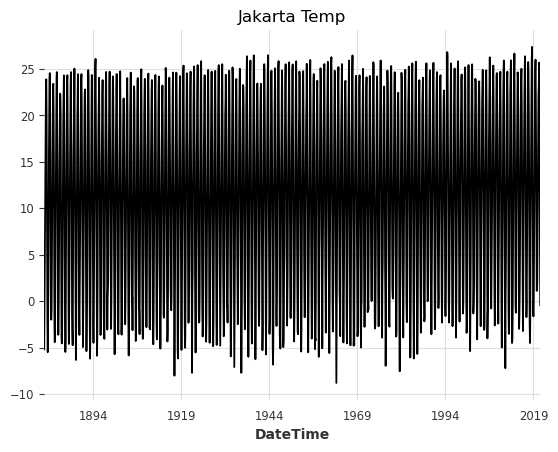

In [6]:
rawdata = pd.read_csv("../data/all_cities_month_temp_df.csv")
rawdata = rawdata.loc[rawdata.loc[:,"city_num"] == 0]
rawdata["DateTime"] = rawdata["year"].astype('str') + '-' + rawdata["month"].astype('str')
rawdata = rawdata.loc[:,["DateTime", "Monthly Anamoly"]]
rawdata["DateTime"] = pd.to_datetime(rawdata["DateTime"])
rawdata = rawdata.loc[rawdata['DateTime'] >= '1880-01-01']
rawdata.set_index("DateTime", inplace=True, drop=True)
display(rawdata.head())

rawdata["Monthly Anamoly"].plot()
plt.title("Jakarta Temp")

In [7]:
series = TimeSeries.from_dataframe(rawdata).astype(np.float32)
scaler = Scaler()
train = series
# train, val = series.split_after(pd.Timestamp("20141201"))

Text(0.5, 1.0, 'Jakarta Temp')

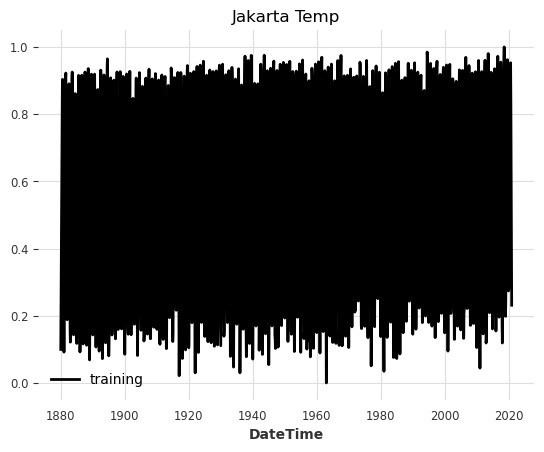

In [8]:
train_scaled = scaler.fit_transform(train)
# val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

train_scaled.plot(label="training")
# val_scaled.plot(label="val")
plt.title("Jakarta Temp")

In [9]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=480,
    output_chunk_length=60,
    generic_architecture=False,
    num_blocks=7,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=64,
    random_state=156,
    model_name=model_name,
    # save_checkpoints=True,
    # force_reset=True,
    **generate_torch_kwargs(),
)

In [10]:
model_nbeats.fit(train_scaled)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=False, num_stacks=30, num_blocks=7, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=480, output_chunk_length=60, n_epochs=100, nr_epochs_val_period=1, batch_size=64, random_state=156, model_name=nbeats_run, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x3157fcdf0>]})

In [11]:
#model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [11]:
from darts.metrics import rmse, smape, mape

def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(12, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(f"Seoul's MAPE: {mape(ts_transformed.univariate_component(0), pred_series)}")
    plt.ylabel('scaled temperature')
    plt.legend()

In [12]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=pd.Timestamp('2015-01-01'),
    # forecast_horizon=120,
    stride=1,
    retrain=False,
    verbose=True,
)

pred_series = concatenate(pred_series)

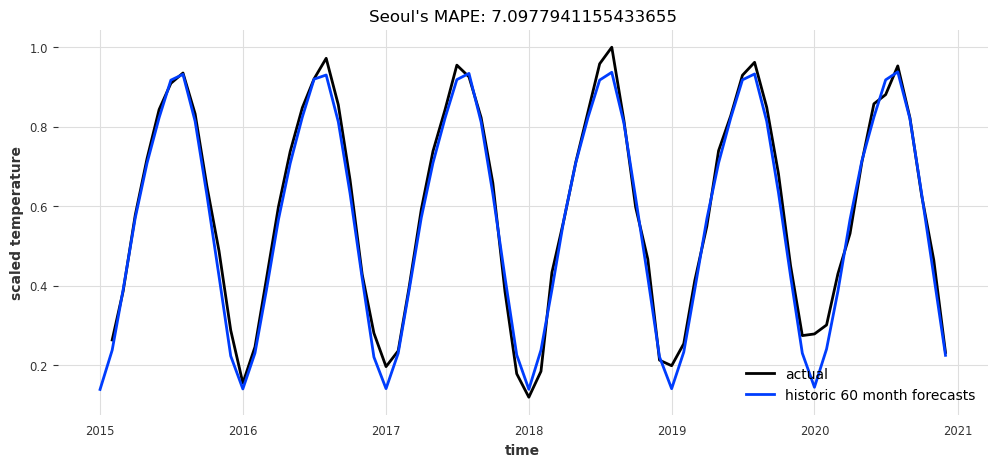

In [13]:
display_forecast(
    pred_series,
    series_scaled,
    "60 month",
    start_date=pd.Timestamp('2015-01-01'),
)

In [14]:
pred_series = model_nbeats.predict(12*80)
pred_series = concatenate(pred_series)

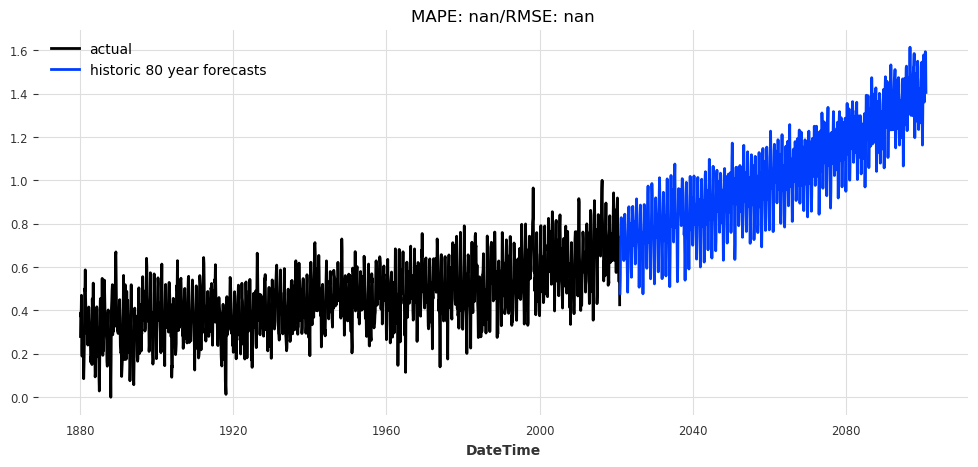

In [15]:
display_forecast(
    pred_series,
    series_scaled,
    "80 year",
    start_date=pd.Timestamp('1880-01-01'),
)

In [16]:
scaler.inverse_transform(series=pred_series).to_csv("a.csv")

In [17]:
forecast = pd.read_csv("a.csv").set_index("DateTime", drop=True)
forecast

,Monthly Anamoly
DateTime,
2021-01-01,26.926680
2021-02-01,27.211756
2021-03-01,27.893852
2021-04-01,28.225552
2021-05-01,28.375080
...,...
2100-08-01,30.803045
2100-09-01,31.146074
2100-10-01,31.548523


In [18]:
rawdata

,Monthly Anamoly
DateTime,
1880-01-01,25.046
1880-02-01,26.103
1880-03-01,26.561
1880-04-01,26.476
1880-05-01,26.891
...,...
2020-08-01,28.011
2020-09-01,27.986
2020-10-01,27.150


In [19]:
total = pd.concat([rawdata, forecast], axis=0)

In [22]:
total.to_csv("./NBEATS_forecast/NBEATS_forecast_jakarta.csv", index=True, header=True)
total

,Monthly Anamoly
DateTime,
1880-01-01 00:00:00,25.046000
1880-02-01 00:00:00,26.103000
1880-03-01 00:00:00,26.561000
1880-04-01 00:00:00,26.476000
1880-05-01 00:00:00,26.891000
...,...
2100-08-01,30.803045
2100-09-01,31.146074
2100-10-01,31.548523


In [20]:
month12_ma = total["Monthly Anamoly"].rolling(window=12).mean()
year10_ma = total["Monthly Anamoly"].rolling(window=120).mean()

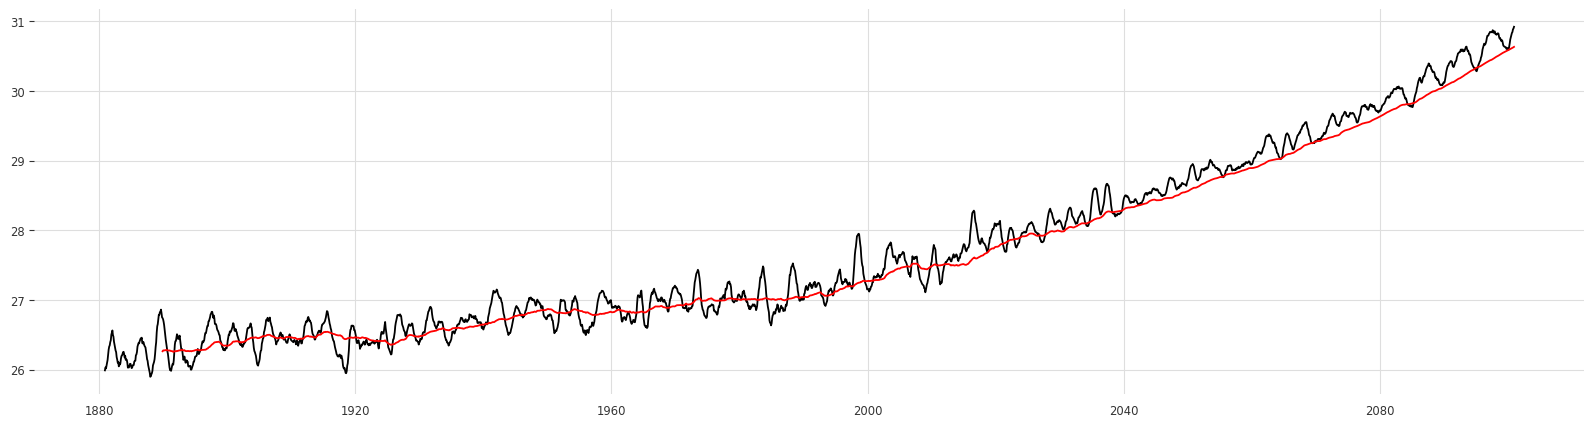

In [21]:
plt.figure(figsize=(20,5))
plt.plot(total.index,month12_ma)
plt.plot(total.index,year10_ma, color='red')